# U-Net

### Goals
In this notebook, you're going to implement a U-Net for a biomedical imaging segmentation task. Specifically, you're going to be labeling neurons, so one might call this a neural neural network! ;) 

Note that this is not a GAN, generative model, or unsupervised learning task. This is a supervised learning task, so there's only one correct answer (like a classifier!) You will see how this component underlies the Generator component of Pix2Pix in the next notebook this week.

### Learning Objectives
1.   Implement your own U-Net.
2.   Observe your U-Net's performance on a challenging segmentation task.


## Getting Started
You will start by importing libraries, defining a visualization function, and getting the neural dataset that you will be using.

#### Dataset
For this notebook, you will be using a dataset of electron microscopy
images and segmentation data. The information about the dataset you'll be using can be found [here](https://www.ini.uzh.ch/~acardona/data.html)! 

> Arganda-Carreras et al. "Crowdsourcing the creation of image
segmentation algorithms for connectomics". Front. Neuroanat. 2015. https://www.frontiersin.org/articles/10.3389/fnana.2015.00142/full

![dataset example](Neuraldatasetexample.png)


In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    # image_shifted = (image_tensor + 1) / 2
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=4)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## U-Net Architecture
Now you can build your U-Net from its components. The figure below is from the paper, [*U-Net: Convolutional Networks for Biomedical Image Segmentation*](https://arxiv.org/abs/1505.04597), by Ronneberger et al. 2015. It shows the U-Net architecture and how it contracts and then expands.

<!-- "[i]t consists of a contracting path (left side) and an expansive path (right side)" (Renneberger, 2015) -->

![Figure 1 from the paper, U-Net: Convolutional Networks for Biomedical Image Segmentation](https://drive.google.com/uc?export=view&id=1XgJRexE2CmsetRYyTLA7L8dsEwx7aQZY)

In other words, images are first fed through many convolutional layers which reduce height and width while increasing the channels, which the authors refer to as the "contracting path." For example, a set of two 2 x 2 convolutions with a stride of 2, will take a 1 x 28 x 28 (channels, height, width) grayscale image and result in a 2 x 14 x 14 representation. The "expanding path" does the opposite, gradually growing the image with fewer and fewer channels.

## Contracting Path
You will first implement the contracting blocks for the contracting path. This path is the encoder section of the U-Net, which has several downsampling steps as part of it. The authors give more detail of the remaining parts in the following paragraph from the paper (Renneberger, 2015):

>The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two 3 x 3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels.

<details>
<summary>
<font size="3" color="green">
<b>Optional hints for <code><font size="4">ContractingBlock</font></code></b>
</font>
</summary>

1.    Both convolutions should use 3 x 3 kernels.
2.    The max pool should use a 2 x 2 kernel with a stride 2.
</details>

In [8]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CLASS: ContractingBlock
class ContractingBlock(nn.Module):
    '''
    ContractingBlock Class
    Performs two convolutions followed by a max pool operation.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels):
        super(ContractingBlock, self).__init__()
        # You want to double the number of channels in the first convolution
        # and keep the same number of channels in the second.
        #### START CODE HERE ####
        self.conv1 = nn.Conv2d(input_channels, 2*input_channels, kernel_size=3)
        self.conv2 = nn.Conv2d(2*input_channels, 2*input_channels, kernel_size=3)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        #### END CODE HERE ####

    def forward(self, x):
        '''
        Function for completing a forward pass of ContractingBlock: 
        Given an image tensor, completes a contracting block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x
    
    # Required for grading
    def get_self(self):
        return self

In [9]:
#UNIT TEST
def test_contracting_block(test_samples=100, test_channels=10, test_size=50):
    test_block = ContractingBlock(test_channels)
    test_in = torch.randn(test_samples, test_channels, test_size, test_size)
    test_out_conv1 = test_block.conv1(test_in)
    # Make sure that the first convolution has the right shape
    assert tuple(test_out_conv1.shape) == (test_samples, test_channels * 2, test_size - 2, test_size - 2)
    # Make sure that the right activation is used
    assert torch.all(test_block.activation(test_out_conv1) >= 0)
    assert torch.max(test_block.activation(test_out_conv1)) >= 1
    test_out_conv2 = test_block.conv2(test_out_conv1)
    # Make sure that the second convolution has the right shape
    assert tuple(test_out_conv2.shape) == (test_samples, test_channels * 2, test_size - 4, test_size - 4)
    test_out = test_block(test_in)
    # Make sure that the pooling has the right shape
    assert tuple(test_out.shape) == (test_samples, test_channels * 2, test_size // 2 - 2, test_size // 2 - 2)

test_contracting_block()
test_contracting_block(10, 9, 8)
print("Success!")

Success!


## Expanding Path
Next, you will implement the expanding blocks for the expanding path. This is the decoding section of U-Net which has several upsampling steps as part of it. In order to do this, you'll also need to write a crop function. This is so you can crop the image from the *contracting path* and concatenate it to the current image on the expanding path—this is to form a skip connection. Again, the details are from the paper (Renneberger, 2015):

>Every step in the expanding path consists of an upsampling of the feature map followed by a 2 x 2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. The cropping is necessary due to the loss of border pixels in every convolution.

<!-- so that the expanding block can resize the input from the contracting block can have the same size as the input from the previous layer -->

*Fun fact: later models based on this architecture often use padding in the convolutions to prevent the size of the image from changing outside of the upsampling / downsampling steps!*

<details>
<summary>
<font size="3" color="green">
<b>Optional hint for <code><font size="4">ExpandingBlock</font></code></b>
</font>
</summary>

1.    The concatenation means the number of channels goes back to being input_channels, so you need to halve it again for the next convolution.
</details>

In [23]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: crop
def crop(image, new_shape):
    '''
    Function for cropping an image tensor: Given an image tensor and the new shape,
    crops to the center pixels.
    Parameters:
        image: image tensor of shape (batch size, channels, height, width)
        new_shape: a torch.Size object with the shape you want x to have
    '''
    # There are many ways to implement this crop function, but it's what allows
    # the skip connection to function as intended with two differently sized images!
    #### START CODE HERE ####
    m_h = int(image.shape[2] / 2)
    m_w = int(image.shape[3] / 2)
    start_h = int(m_h - new_shape[2] / 2)
    end_h = int(m_h + new_shape[2] / 2)
    start_w = int(m_w - new_shape[3] / 2)
    end_w = int(m_w + new_shape[3] / 2)
    cropped_image = image[:, :, start_h:end_h, start_w:end_w]
    #### END CODE HERE ####
    return cropped_image

In [24]:
#UNIT TEST
def test_expanding_block_crop(test_samples=100, test_channels=10, test_size=100):
    # Make sure that the crop function is the right shape
    skip_con_x = torch.randn(test_samples, test_channels, test_size + 6, test_size + 6)
    x = torch.randn(test_samples, test_channels, test_size, test_size)
    cropped = crop(skip_con_x, x.shape)
    assert tuple(cropped.shape) == (test_samples, test_channels, test_size, test_size)

    # Make sure that the crop function takes the right area
    test_meshgrid = torch.meshgrid([torch.arange(0, test_size), torch.arange(0, test_size)])
    test_meshgrid = test_meshgrid[0] + test_meshgrid[1]
    test_meshgrid = test_meshgrid[None, None, :, :].float()
    cropped = crop(test_meshgrid, torch.Size([1, 1, test_size // 2, test_size // 2]))
    assert cropped.max() == (test_size - 1) * 2 - test_size // 2
    assert cropped.min() == test_size // 2
    assert cropped.mean() == test_size - 1

    test_meshgrid = torch.meshgrid([torch.arange(0, test_size), torch.arange(0, test_size)])
    test_meshgrid = test_meshgrid[0] + test_meshgrid[1]
    crop_size = 5
    test_meshgrid = test_meshgrid[None, None, :, :].float()
    cropped = crop(test_meshgrid, torch.Size([1, 1, crop_size, crop_size]))
    assert cropped.max() <= (test_size + crop_size - 1) and cropped.max() >= test_size - 1
    assert cropped.min() >= (test_size - crop_size - 1) and cropped.min() <= test_size - 1
    assert abs(cropped.mean() - test_size) <= 2

test_expanding_block_crop()
print("Success!")

Success!


In [27]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CLASS: ExpandingBlock
class ExpandingBlock(nn.Module):
    '''
    ExpandingBlock Class
    Performs an upsampling, a convolution, a concatenation of its two inputs,
    followed by two more convolutions.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels):
        super(ExpandingBlock, self).__init__()
        # "Every step in the expanding path consists of an upsampling of the feature map"
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        # "followed by a 2x2 convolution that halves the number of feature channels"
        # "a concatenation with the correspondingly cropped feature map from the contracting path"
        # "and two 3x3 convolutions"
        #### START CODE HERE ####
        self.conv1 = nn.Conv2d(input_channels, input_channels//2, kernel_size=2)
        self.conv2 = nn.Conv2d(input_channels, input_channels//2, kernel_size=3)
        self.conv3 = nn.Conv2d(input_channels//2, input_channels//2, kernel_size=3)
        #### END CODE HERE ####
        self.activation = nn.ReLU() # "each followed by a ReLU"
 
    def forward(self, x, skip_con_x):
        '''
        Function for completing a forward pass of ExpandingBlock: 
        Given an image tensor, completes an expanding block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
            skip_con_x: the image tensor from the contracting path (from the opposing block of x)
                    for the skip connection
        '''
        x = self.upsample(x)
        x = self.conv1(x)
        skip_con_x = crop(skip_con_x, x.shape)
        x = torch.cat([x, skip_con_x], axis=1)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.activation(x)
        return x
    
    # Required for grading
    def get_self(self):
        return self

In [28]:
#UNIT TEST
def test_expanding_block(test_samples=100, test_channels=10, test_size=50):
    test_block = ExpandingBlock(test_channels)
    skip_con_x = torch.randn(test_samples, test_channels // 2, test_size * 2 + 6, test_size * 2 + 6)
    x = torch.randn(test_samples, test_channels, test_size, test_size)
    x = test_block.upsample(x)
    x = test_block.conv1(x)
    # Make sure that the first convolution produces the right shape
    assert tuple(x.shape) == (test_samples, test_channels // 2,  test_size * 2 - 1, test_size * 2 - 1)
    orginal_x = crop(skip_con_x, x.shape)
    x = torch.cat([x, orginal_x], axis=1)
    x = test_block.conv2(x)
    # Make sure that the second convolution produces the right shape
    assert tuple(x.shape) == (test_samples, test_channels // 2,  test_size * 2 - 3, test_size * 2 - 3)
    x = test_block.conv3(x)
    # Make sure that the final convolution produces the right shape
    assert tuple(x.shape) == (test_samples, test_channels // 2,  test_size * 2 - 5, test_size * 2 - 5)
    x = test_block.activation(x)

test_expanding_block()
print("Success!")

Success!


## Final Layer
Now you will write the final feature mapping block, which takes in a tensor with arbitrarily many tensors and produces a tensor with the same number of pixels but with the correct number of output channels. From the paper (Renneberger, 2015):

>At the final layer a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. In total the network has 23 convolutional layers.


In [29]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CLASS: FeatureMapBlock
class FeatureMapBlock(nn.Module):
    '''
    FeatureMapBlock Class
    The final layer of a UNet - 
    maps each pixel to a pixel with the correct number of output dimensions
    using a 1x1 convolution.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        # "Every step in the expanding path consists of an upsampling of the feature map"
        #### START CODE HERE ####
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)
        #### END CODE HERE ####

    def forward(self, x):
        '''
        Function for completing a forward pass of FeatureMapBlock: 
        Given an image tensor, returns it mapped to the desired number of channels.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv(x)
        return x

In [30]:
# UNIT TEST
assert tuple(FeatureMapBlock(10, 60)(torch.randn(1, 10, 10, 10)).shape) == (1, 60, 10, 10)
print("Success!")

Success!


## U-Net

Now you can put it all together! Here, you'll write a `UNet` class which will combine a series of the three kinds of blocks you've implemented.

In [33]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CLASS: UNet
class UNet(nn.Module):
    '''
    UNet Class
    A series of 4 contracting blocks followed by 4 expanding blocks to 
    transform an input image into the corresponding paired image, with an upfeature
    layer at the start and a downfeature layer at the end
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels, hidden_channels=64):
        super(UNet, self).__init__()
        # "Every step in the expanding path consists of an upsampling of the feature map"
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        self.contract3 = ContractingBlock(hidden_channels * 4)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.expand1 = ExpandingBlock(hidden_channels * 16)
        self.expand2 = ExpandingBlock(hidden_channels * 8)
        self.expand3 = ExpandingBlock(hidden_channels * 4)
        self.expand4 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)

    def forward(self, x):
        '''
        Function for completing a forward pass of UNet: 
        Given an image tensor, passes it through U-Net and returns the output.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        # Keep in mind that the expand function takes two inputs, 
        # both with the same number of channels. 
        #### START CODE HERE ####
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        x5 = self.expand1(x4, x3)
        x6 = self.expand2(x5, x2)
        x7 = self.expand3(x6, x1)
        x8 = self.expand4(x7, x0)
        xn = self.downfeature(x8)
        #### END CODE HERE ####
        return xn

In [34]:
#UNIT TEST
test_unet = UNet(1, 3)
assert tuple(test_unet(torch.randn(1, 1, 256, 256)).shape) == (1, 3, 117, 117)
print("Success!")

Success!


## Training

Finally, you will put this into action!
Remember that these are your parameters:
  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   input_dim: the number of channels of the input image
  *   label_dim: the number of channels of the output image
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   initial_shape: the size of the input image (in pixels)
  *   target_shape: the size of the output image (in pixels)
  *   device: the device type

This should take only a few minutes to train!

In [35]:
import torch.nn.functional as F
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
input_dim = 1
label_dim = 1
display_step = 20
batch_size = 4
lr = 0.0002
initial_shape = 512
target_shape = 373
device = 'cuda'

In [36]:
from skimage import io
import numpy as np
volumes = torch.Tensor(io.imread('train-volume.tif'))[:, None, :, :] / 255
labels = torch.Tensor(io.imread('train-labels.tif', plugin="tifffile"))[:, None, :, :] / 255
labels = crop(labels, torch.Size([len(labels), 1, target_shape, target_shape]))
dataset = torch.utils.data.TensorDataset(volumes, labels)

Epoch 0: Step 0: U-Net loss: 0.705604076385498


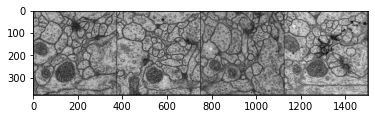

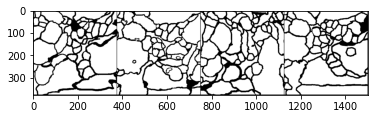

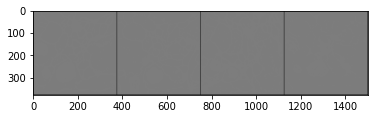

Epoch 2: Step 20: U-Net loss: 0.5778344869613647


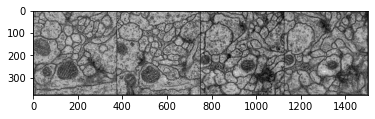

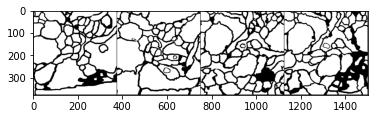

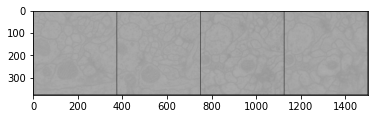

Epoch 5: Step 40: U-Net loss: 0.48720207810401917


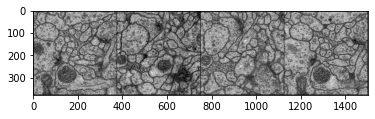

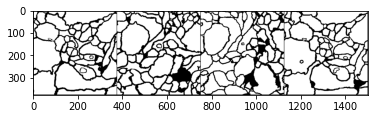

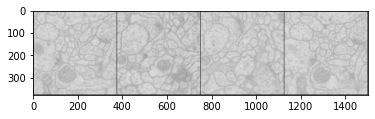

KeyboardInterrupt: 

In [37]:
def train():
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True)
    unet = UNet(input_dim, label_dim).to(device)
    unet_opt = torch.optim.Adam(unet.parameters(), lr=lr)
    cur_step = 0

    for epoch in range(n_epochs):
        for real, labels in tqdm(dataloader):
            cur_batch_size = len(real)
            # Flatten the image
            real = real.to(device)
            labels = labels.to(device)

            ### Update U-Net ###
            unet_opt.zero_grad()
            pred = unet(real)
            unet_loss = criterion(pred, labels)
            unet_loss.backward()
            unet_opt.step()

            if cur_step % display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}: U-Net loss: {unet_loss.item()}")
                show_tensor_images(
                    crop(real, torch.Size([len(real), 1, target_shape, target_shape])), 
                    size=(input_dim, target_shape, target_shape)
                )
                show_tensor_images(labels, size=(label_dim, target_shape, target_shape))
                show_tensor_images(torch.sigmoid(pred), size=(label_dim, target_shape, target_shape))
            cur_step += 1

train()